#### Import the libraries

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing as ps
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#### Reading the dataset and getting to know the data

In [89]:
df = pd.read_csv('google/google-3y.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-03,59.000000,59.452999,58.121498,59.391499,59.391499,32424000
1,2019-10-04,59.594501,60.571999,59.458500,60.450001,60.450001,23248000
2,2019-10-07,60.220001,60.910198,60.187500,60.383999,60.383999,16858000
3,2019-10-08,59.879501,60.304001,59.450500,59.456501,59.456501,20786000
4,2019-10-09,59.967499,60.417500,59.881500,60.115501,60.115501,17354000


In [90]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,755.000000,755.000000,755.000000,755.000000,755.000000,7.550000e+02
mean,102.319797,103.489279,101.216886,102.364671,102.364671,3.046936e+07
std,29.015221,29.195379,28.717563,28.931069,28.931069,1.323529e+07
min,52.825500,53.566002,50.676800,52.831001,52.831001,6.936000e+06
25%,73.649002,74.493752,73.083500,73.886502,73.886502,2.182500e+07
50%,104.250000,105.824997,103.309998,104.758499,104.758499,2.734000e+07
75%,129.909248,130.964875,127.539749,129.247002,129.247002,3.476700e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,8.975000e+07


As it is observable from this table, we have stock data for 755 days (during last 3 years
which is not including holidays and weekends). During this time, the Google stock price has seen
a considerable change. For example, for 'High' value, the minimum is around $\$$53 while its maximum is
about $\$$152. Let's plot this trend to see its change during this time:

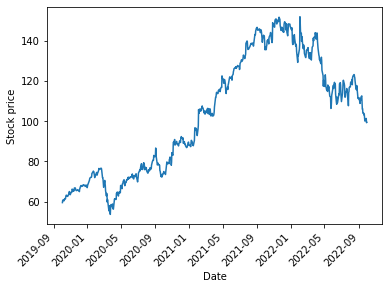

In [91]:
date_time = pd.to_datetime(df['Date'])
DF = df.iloc[:, 2:3]
DF = DF.set_index(date_time)
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.plot(DF)
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

As mentioned, Google's stock price has seen a significant change from 2012 until today.

Finally, we can check the total info of our data and see if our data has any missing value.

In [92]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       755 non-null    object 
 1   Open       755 non-null    float64
 2   High       755 non-null    float64
 3   Low        755 non-null    float64
 4   Close      755 non-null    float64
 5   Adj Close  755 non-null    float64
 6   Volume     755 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.4+ KB


In [93]:
df.isnull().sum()/len(df)

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

As you can see, we don't have any missing value in our dataset.


## Stock prediction using LSTM
#### Data preparattion

As mentioned previously, I consider 'High' data from our dataset for our analysis and stock price prediction.
So, let's load it into a separate dataframe and do some data preprocessing.

In [94]:
high_df = df.iloc[:, 2:3]
data_scaler = ps.MinMaxScaler(feature_range=(0,1))
scaled_data = data_scaler.fit_transform(high_df)

Here I used MinMaxScaler from sklearn library in order to scale our
data into range 0 and 1.

Our scaled data looks like:

In [95]:
scaled_data[:5]

array([[0.05974584],
       [0.07110233],
       [0.07453463],
       [0.06838247],
       [0.06953435]])

#### Train-Test split

Now, it's the time to split our data into train and test sets. I use a
80-20 proportion for train and test sets.

In [96]:
train_size = int(len(scaled_data) * 0.8)
test_size = int(len(scaled_data) - train_size)
train, test = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data),:]

Training an LSTM is a bit tricky as it needs a window of data to be trained on. To make our time
series data to a supervised learning problem, I use a sliding window method with a window size
of 20 and the next day as the label for this window of data.

In [97]:
def sliding_window_split(data, window_size):

    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])

    return np.array(X), np.array(Y)

w = 20
X_train, Y_train = sliding_window_split(train, w)
X_test, Y_test = sliding_window_split(test, w)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#### Building and fitting the model

In [98]:
def create_model():

    model = Sequential()
    model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
                   input_shape = (X_train.shape[1], w)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 25, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

model = create_model()

In [99]:
model.fit(X_train, Y_train, epochs=100, batch_size=20)

Epoch 1/100
30/30 [==============================] - 2s 2ms/step - loss: 0.2708
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0639
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 6/100
30/30 [==============================] 

#### Model evaluation

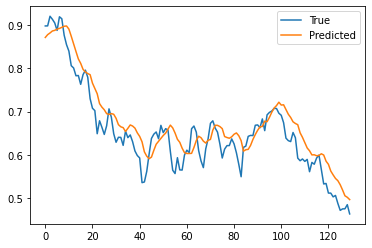

In [100]:
predicted_stock_price = model.predict(X_test)

plt.plot(Y_test, label='True')
plt.plot(predicted_stock_price, label='Predicted')
plt.legend()

As this diagram shows, the model performs pretty good in predicting the stock price
 of Google on the test data.